# The Length of an MTZ Monlith

The math here is described in some depth from page 19 of my notebook. We are assuming constant-pattern behaviour, which means we can modify the code in SIPS Model.jl by simply replacing $p(t)$ (the external gas partial pressure) with the function:

$$
p = \frac{p_0}{\bar{q}_0}\frac{1}{\delta}\int_{0}^{\delta} q(x) dx = \frac{p_0}{\bar{q}_0}\frac{N}{\delta}
$$

Here $p$ is the gas phase concentration of adsorbed gas (and $p_0$ is the inlet concentration), $\bar{q}$ is the mean gas concentration inside the emsulion (and $\bar{q}_0$ is the value at equilibrium with $p_0$ - see below.) $\delta$ is the thickness of the wall on the inside of the emulsion. Apart from the function $g(\cdot)$ and the specification of $p_0$, we need not add anything else to our model. However, we must be careful to make sure that our *reaction* model inside our particles, as described by $f(\cdot)$, is consistent with our choice of $\bar{q}_0$ for a given value of $p_0$. The simplest way to do this will be to call the time-dependent solution, LinearSIP, with all of the same parameters and $p(t)=p_0$, and then find $\bar{q}_0$ from the solution at large $t_f$. You may realise this means we don't explicitly need the VLE data: instead it must be contained in the function $f$, which relates reaction rate to solid loading and partial pressure (well, $c$, but they're related via Henry's constant.) The simplest way to do this would be to make $f$ a reversible reaction, but for more complex systems (e.g. buffer systems) more subtle measures may be necessary. To start, I will consider the simplest system, in which the reaction is irreversible. We then have $\bar{q}_0=\text{Constant}$: an *extremely* favourable isotherm, which looks like a step function.

In [5]:
using DifferentialEquations
using Plots

#Function to model the absorption of gas into SIP material in linear coordinates via MOL approach.
#Discussed on p. 8 of workbook.
#Inputs: f - function for rate of change in reactive species concentration. 
#L - length of domain, m
#tf - end time of simulation, s. 
#p - partial pressure of gas above SIP (this must be a function of time.), Pa.
#c0 and w0 - initial CO2 and reactant concentration
#k2 - second order rate constant, m3/mol.s
#Ss and Sl - solubility of gas in solid and liquid phases, respectively, mol/m3.Pa
#Ds and Dl - diffusivity of gas in solid and liquid phases, respectively, m2/s
#ɛ - The solid fraction inside the particle.
#m - The number of mesh points.
function LinearSIP(f,L,tf,p,c0,w0,k2,Ss,Sl,Ds,Dl,ɛ,m)
    
    #Pertinent Mesh Values
    h = L/m         #Distance between neighbouring grid points
    
    #Generic Ddash and kdash parameters
    Ddash = (Ds*ɛ+Dl*(1-ɛ)*Sl/Ss) / (ɛ+(1-ɛ)*Sl/Ss)
    kdash = (k2*Sl/Ss*(1-ɛ))      / (ɛ+(1-ɛ)*Sl/Ss)
    
    #Define DE Problem
    function main(t,u,dudt)
        #Extract values from u
        c = u[1:m]
        w = u[m+1:2m]
        
        #Calculate change of concentration due to diffusion and reaction
        for i = 1:2m+1
            if i == 1
                dudt[i] = Ddash/h^2*(2c[2]-2c[1]) - kdash*c[1]*w[1]
            elseif 2 <= i <= m-1
                dudt[i] = Ddash/h^2*(c[i-1]-2c[i]+c[i+1]) - kdash*c[i]*w[i]
            elseif i == m
                dudt[i] = Ddash/h^2*(c[m-1]-2c[m] + Ss*p(t)) - kdash*c[m]*w[m] 
            elseif m+1 <= i <= 2m
                dudt[i] = f(c[i-m],w[i-m])
            elseif i == 2m+1
                dudt[i] = ((3/2*Ss*p(t)-2*c[m]+1/2*c[m-1])/h)*(Ds*ɛ+Dl*(1-ɛ)*Sl/Ss)
            end
        end
    end

    #Initial Conditions and timespan
    u0 = [c0*ones(m);w0*ones(m);0.0]
    tspan = (0.0,tf)

    #Define and solve problem
    prob = ODEProblem(main,u0,tspan)
    sol = solve(prob, Rosenbrock23());
    return sol
end


#Function to model the Length of the MTZ of a Monolith coated with SIP This function returns the MTZ in the *time* domain - we then need to convert it to a space domain.
#Discussed on p. 19 of workbook.
#Inputs: f - function for rate of change in reactive species concentration. 
#δ - width of SIP in monolith, m
#tf - end time of simulation, s. 
#w_initial - Initial concentration of reactive species in solvent, mol/m3 solvent
#k2 - second order rate constant, m3/mol.s
#Ss and Sl - solubility of gas in solid and liquid phases, respectively, mol/m3.Pa
#Ds and Dl - diffusivity of gas in solid and liquid phases, respectively, m2/s
#ɛ_p - The solid fraction inside the particle.
#m - The number of mesh points.
#p0 - The inlet partial pressure of gas.
#w - width of SIP on wall
#v - interstitial gas velocity (though monolith tubes), m/s
#T - Temperature, K
function MonolithMTZintime(f,δ,tf,w_initial,k2,Ss,Sl,Ds,Dl,ɛ_p,m,p_0)
    
    #Calculate qbar_0 from p_0, using LinearSIP
    p_0func(t) = p_0   #Constant pressure function
    c0 = 0.0;    #Unlike w_initial, this doesn't matter, as we're calculating equilibrium values.
    constantp0sol = LinearSIP(f,δ,1e9,p_0func,c0,w_initial,k2,Ss,Sl,Ds,Dl,ɛ_p,m)
    qbar_0 = constantp0sol(1e9)[2m+1]/δ
    
    
    #Pertinent Mesh Values
    h = δ/m         #Distance between neighbouring grid points
    
    #Generic Ddash and kdash parameters
    Ddash = (Ds*ɛ_p+Dl*(1-ɛ_p)*Sl/Ss) / (ɛ_p+(1-ɛ_p)*Sl/Ss)
    kdash = (k2*Sl/Ss*(1-ɛ_p))        / (ɛ_p+(1-ɛ_p)*Sl/Ss)
    
    #Define DE Problem
    function main(t,u,dudt)
        #Extract values from u
        c = u[1:m]
        w = u[m+1:2m]
        N = u[2m+1]
        
        #Calculate new external pressure
        p = p_0/qbar_0*N/δ
        
        #Calculate change of concentration due to diffusion and reaction
        for i = 1:2m+1
            if i == 1
                dudt[i] = Ddash/h^2*(2c[2]-2c[1]) - kdash*c[1]*w[1]
            elseif 2 <= i <= m-1
                dudt[i] = Ddash/h^2*(c[i-1]-2c[i]+c[i+1]) - kdash*c[i]*w[i]
            elseif i == m
                dudt[i] = Ddash/h^2*(c[m-1]-2c[m] + Ss*p) - kdash*c[m]*w[m] 
            elseif m+1 <= i <= 2m
                dudt[i] = f(c[i-m],w[i-m])
            elseif i == 2m+1
                dudt[i] = ((3/2*Ss*p-2*c[m]+1/2*c[m-1])/h)*(Ds*ɛ_p+Dl*(1-ɛ_p)*Sl/Ss)
            end
        end
    end

    #Initial Conditions and timespan
    u0 = [1e-6*ones(m);w_initial*ones(m);1e-6]
    tspan = (0.0,tf)

    #Define and solve problem
    prob = ODEProblem(main,u0,tspan)
    sol = solve(prob, Rosenbrock23());
    return [sol,qbar_0]
end


sys:1: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


MonolithMTZintime (generic function with 1 method)

In [6]:
#Example with reasonably realistic values.

δ = 200e-6      #m
k2 = 20.0       #m3/mol.s      Taken at infinite dilution from confirmation report.
Ss = 5.67e-4    #mol/Pa.m3     From http://onlinelibrary.wiley.com/doi/10.1002/(SICI)1099-0488(20000201)38:3%3C415::AID-POLB8%3E3.0.CO;2-Z/full Good references at "Gas permeability, diffusivity and solubility of nitrogen, helium, methane, carbon dioxide and formaldehyde in dense polymeric membranes using a new on-line permeation apparatus"
Sl = 2.88e-4    #mol/Pa.m3     From Vericella (2015) See also confirmation report
Ds = 2.2e-9     #m2/s          From http://onlinelibrary.wiley.com/doi/10.1002/(SICI)1099-0488(20000201)38:3%3C415::AID-POLB8%3E3.0.CO;2-Z/full Good references at "Gas permeability, diffusivity and solubility of nitrogen, helium, methane, carbon dioxide and formaldehyde in dense polymeric membranes using a new on-line permeation apparatus"
Dl = 1.78e-9    #m2/s          From Vericella (2015) See also confirmation report
p_0 = 10130     #Pa            Consider 10% CO2 environment.
tf = 15000.0      #s 
ɛ_p = 0.5       #              Voidage of SIPS material.

#This function is a little subtle. See my workbook, after p. 8
ftemp = function (c,w)
   #Data for Function
    Keq = 5.0                    #m3/mol   Calculate in more detail later. Sourced from http://clas.sa.ucsb.edu/staff/Resource%20Folder/Chem109ABC/Acid,%20Base%20Strength/Table%20of%20Acids%20w%20Kas%20and%20pKas.pdf
    cKion = 6000                 #mol/m3. Based on 0.3mol/L solution of K2CO3
    nco2dot = k2*c*Sl/Ss*w       #mol/m3.s    Rate of reaction of CO2
    ξdot = 2*nco2dot/cKion       #1/s. Rate of change of loading
    ξ = 1/(1+2Keq*w)             #loading
    wdot = -ξdot/(2*Keq*ξ^2)     #mol/m3.s Rate of change of OH- concentration
    return wdot
end
w_initial = 1e3;     #Initial OH- concentration, mol/m3
m = 50

@time (sol, qbar_0) = MonolithMTZintime(ftemp,δ,tf,w_initial,k2,Ss,Sl,Ds,Dl,ɛ_p,m,p_0)

#Convert to length-scale
w = 5*δ         #m             Width of monolith cell
v = 0.5         #m/s           Superficial Gas Velocity
T = 300         #K             Temperature of flue gas
R = 8.314       #J/mol.K       Universal gas constant
ɛ = (w-2δ)/(w+2δ)             #Bulk Voidage inside bed
β = ɛ*v/(ɛ+(1-ɛ)*qbar_0/(p_0/(R*T)))    #Velocity of MTZ
MTZinspace(z) = sol(z/β)[2m+1]/(δ*qbar_0)      #Function for q/qbar_0 in space (constant pattern)

  8.461854 seconds (19.94 M allocations: 1.303 GB, 3.76% gc time)



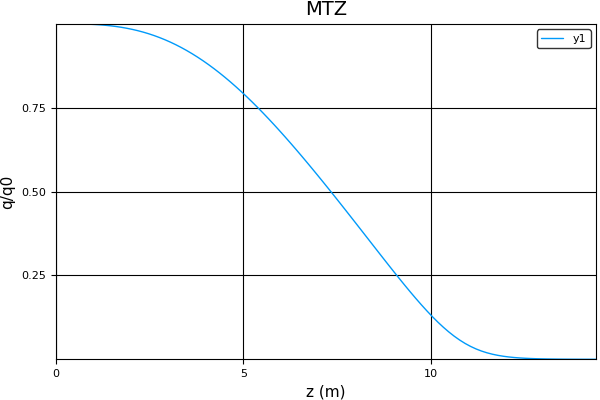

In [7]:
plot(linspace(0,0.95*β*tf,100),[1-MTZinspace(z) for z in linspace(0,0.95*β*tf,100)], title="MTZ", xlabel="z (m)", ylabel="q/q0")

With a few kPa pressure drop.

In [49]:
15/β

3729.859230715267

## 30 wt% K2CO3 

Comments:

- There is a lot of uncertainty over the Henry's law Constant (i.e. $S_l$) of concentrated K2CO3 solutions. 

## Protic Ionic Liquids

Comments

 - Data comes from
 
 
 